# NRM python upstream client library tutorial

This tutorial covers the use of NRM's python upstream client library, in the context of running an external resource management strategy. Its cell's output are deterministic, and the executed version that is vendored in the source tree is checked by the project's CI, so its behavior should always be up-to-date with the latest version of the software, and no cells should be throwing exceptions.  



## Setup

This notebook uses `nrm`'s python library bindings.  

In [12]:
# the nrm python bindings
import nrm.tooling as nrm
# other imports
import time
import json
import pandas as pd
import inspect
import matplotlib.pyplot as plt
from collections import defaultdict

The `nrmd` context manager is the preffered way to use the `nrm.tooling` module:

In [2]:
with nrm.nrmd({}) as d:
    print(d.upstream_recv())

{'pubMeasurements': [1604027239391853.5, [{'time': 1604027239391853.5, 'sensorValue': 6.367862870816432, 'sensorID': 'RaplKey (PackageID 0)'}]]}


`nrmd` returns an object of type `NRMD`, which supports the following methods:

In [3]:
for a, x in inspect.getmembers(nrm.NRMD(""), predicate=inspect.ismethod): print("%s: %s" % (a, x.__doc__))

__init__: None
actuate:  Upstream request: Run an available action 
all_finished:  Upstream request: Checks NRM to see whether all tasks are finished. 
get_cpd:  Upstream request: Obtain the current Control Problem Description 
get_state:  Upstream request: Obtain the current daemon state 
run:  Upstream request: Run an application via NRM.
upstream_recv:  Upstream listen: Receive a message from NRM's upstream API. 


The next cell defines some daemon configurations and workloads. Please see notebook [notebooks/configuration.ipynb](notebooks/configuration.ipynb) for an overview of `nrmd`'s configuration format configuration format, as well as for an overview of manifests.

In [4]:
powerCaps = [60, 75, 60, 100, 110, 120, 150, 180, 210]
daemonCfgs = {
    "manyActions": {
        "raplCfg": {
            "raplActions": [{"microwatts": 1_000_000 * p} for p in powerCaps],
            "referencePower": {"microwatts": 250_000_000},
            "raplPath": "/sys/devices/virtual/powercap/intel-rapl",
        },
        "passiveSensorFrequency" : { "hertz" : 10 }
    }
}

workloads = {
    "dummy": [
        {
            "cmd": "sleep",
            "args": ["10"],  # running the sleep command for 10 seconds.
            "sliceID": "toto",
            "manifest": {
                "app": {
                    "perfwrapper": {
                        "perfLimit": 100000,
                        "perfFreq": {"hertz": 10},
                    },
                },
                "name": "perfwrap",
            },
        }
    ],
    # "other":your code
}

The next cell defines some experiments:

In [5]:
experiments = {"example": (daemonCfgs["manyActions"], workloads["dummy"])}

## Running experiments

First, we set correct permissions on the RAPL sysfs interface.

In [6]:
%%bash
#cd /sys/devices/virtual/powercap/intel-rapl
#sudo chown $(whoami):users -R *

We can start the daemon and obtain the current control description problem in the following way:

In [7]:
with nrm.nrmd(daemonCfgs["manyActions"]) as d:
    print(d.get_cpd())

Actuators:
  - RaplKey (PackageID 0) : Actuator {actions = [DiscreteDouble {getDiscrete = 60.0},DiscreteDouble {getDiscrete = 75.0},DiscreteDouble {getDiscrete = 60.0},DiscreteDouble {getDiscrete = 100.0},DiscreteDouble {getDiscrete = 110.0},DiscreteDouble {getDiscrete = 120.0},DiscreteDouble {getDiscrete = 150.0},DiscreteDouble {getDiscrete = 180.0},DiscreteDouble {getDiscrete = 210.0}]}
Sensors:
  - RaplKey (PackageID 0) : Sensor {range = 0.0 ... 150.0, maxFrequency = 10.0}
Objectives:
  
Constraints:
  



As you can see, there is one sensor and one actuator, both corresponding to the same RAPL package. Not very interesting until we start a workload. The following cell triggers the first available action from the first actuator.

In [8]:
with nrm.nrmd(daemonCfgs["manyActions"]) as d:
    a = d.get_cpd().actuators()[0]
    actuatorID = a.actuatorID
    action = a.admissibleActions[0]
    d.actuate([nrm.Action(actuatorID, action)])

Internal daemon state inspection, should you need it, is achieved in the following way:

In [9]:
with nrm.nrmd(daemonCfgs["manyActions"]) as d:
    print(d.get_state())

NRMState 
    { pus = fromList 
        [ 
            ( PUID 0
            , PU
            ) 
        , 
            ( PUID 1
            , PU
            ) 
        , 
            ( PUID 2
            , PU
            ) 
        , 
            ( PUID 3
            , PU
            ) 
        , 
            ( PUID 4
            , PU
            ) 
        , 
            ( PUID 5
            , PU
            ) 
        , 
            ( PUID 6
            , PU
            ) 
        , 
            ( PUID 7
            , PU
            ) 
        ] 
    , cores = fromList 
        [ 
            ( CoreID 0
            , Core
            ) 
        , 
            ( CoreID 1
            , Core
            ) 
        , 
            ( CoreID 2
            , Core
            ) 
        , 
            ( CoreID 3
            , Core
            ) 
        ] 
    , packages = fromList 
        [ 
            ( PackageID 0
            , Package 
                { rapl = Just 
                    

### Dummy experiment: printing measurements

We now are ready to run an external resource management strategy. The next cell uses the low-level "upstream listening" message passing interface. Message schemas for this API can be browsed in the [./resources/](./resources/) folder.

In [10]:
for name, (daemonCfg, workloads) in experiments.items():
    with nrm.nrmd(daemonCfg) as d:
        for w in workloads: d.run(**w)
        history = defaultdict(list)
        getCPD = True
        d.actuate([nrm.Action("RaplKey (PackageID 0)", 210)])
        while not d.all_finished():
            msg = d.upstream_recv()
            print("received upstream message: %s" %msg)
            if "pubMeasurements" in msg:
                ts = time.time()
                print(ts)
                if getCPD:
                    getCPD = False
                    time.sleep(1)
                    cpd = dict(d.get_cpd())
                    print("Sensor identifier list:")
                    for sensorID in [sensor[0] for sensor in cpd["sensors"]]:
                        print("- %s" % sensorID)
                    print("Actuator identifier list:")
                    for sensorID in [sensor[0] for sensor in cpd["actuators"]]:
                        print("- %s" % sensorID)
                content = msg["pubMeasurements"][1][0]
                t = content["time"]
                sensorID = content["sensorID"]
                x = content["sensorValue"]
                print("measured at time %s: sensor %s, value %s" % (t, sensorID, x))
                history[sensorID].append((t, x))

received upstream message: {'pubMeasurements': [1604027243846976.8, [{'time': 1604027243846976.8, 'sensorValue': 17.587646857205787, 'sensorID': 'RaplKey (PackageID 0)'}]]}
1604027243.8531184
Sensor identifier list:
- DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0)
- RaplKey (PackageID 0)
Actuator identifier list:
- RaplKey (PackageID 0)
measured at time 1604027243846976.8: sensor RaplKey (PackageID 0), value 17.587646857205787
received upstream message: {'pubMeasurements': [1604027243947954, [{'time': 1604027243947954, 'sensorValue': 17.907231579390388, 'sensorID': 'RaplKey (PackageID 0)'}]]}
1604027244.8597093
measured at time 1604027243947954: sensor RaplKey (PackageID 0), value 17.907231579390388
received upstream message: {'pubMeasurements': [1604027244046995.2, [{'time': 1604027244046995.2, 'sensorValue': 16.373975490114137, 'sensorID': 'RaplKey (PackageID 0)'}]]}
1604027244.8651237
measured at time 1604027244046995.2: sensor RaplKey (PackageID 0), value 1

received upstream message: {'pubPerformance': [1604027245284389.2, '08383fd1-1a5d-11eb-8001-8c1645edb774', 0]}
received upstream message: {'pubMeasurements': [1604027245346959, [{'time': 1604027245346959, 'sensorValue': 22.873182776599776, 'sensorID': 'RaplKey (PackageID 0)'}]]}
1604027245.347903
measured at time 1604027245346959: sensor RaplKey (PackageID 0), value 22.873182776599776
received upstream message: {'pubMeasurements': [1604027245384609.8, [{'time': 1604027245384609.8, 'sensorValue': 0, 'sensorID': 'DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0)'}]]}
1604027245.3859277
measured at time 1604027245384609.8: sensor DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0), value 0
received upstream message: {'pubPerformance': [1604027245384609.8, '08383fd1-1a5d-11eb-8001-8c1645edb774', 0]}
received upstream message: {'pubMeasurements': [1604027245446905.2, [{'time': 1604027245446905.2, 'sensorValue': 23.942859286899996, 'sensorID': 'RaplK

received upstream message: {'pubMeasurements': [1604027246485836.5, [{'time': 1604027246485836.5, 'sensorValue': 0, 'sensorID': 'DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0)'}]]}
1604027246.4868572
measured at time 1604027246485836.5: sensor DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0), value 0
received upstream message: {'pubPerformance': [1604027246485836.5, '08383fd1-1a5d-11eb-8001-8c1645edb774', 0]}
received upstream message: {'pubMeasurements': [1604027246547084.5, [{'time': 1604027246547084.5, 'sensorValue': 19.282983159210048, 'sensorID': 'RaplKey (PackageID 0)'}]]}
1604027246.548445
measured at time 1604027246547084.5: sensor RaplKey (PackageID 0), value 19.282983159210048
received upstream message: {'pubMeasurements': [1604027246586536.8, [{'time': 1604027246586536.8, 'sensorValue': 0, 'sensorID': 'DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0)'}]]}
1604027246.5878615
measured at time 16040272465865

received upstream message: {'pubPerformance': [1604027247587348.5, '08383fd1-1a5d-11eb-8001-8c1645edb774', 0]}
received upstream message: {'pubMeasurements': [1604027247647978.2, [{'time': 1604027247647978.2, 'sensorValue': 18.31003133771174, 'sensorID': 'RaplKey (PackageID 0)'}]]}
1604027247.6492672
measured at time 1604027247647978.2: sensor RaplKey (PackageID 0), value 18.31003133771174
received upstream message: {'pubMeasurements': [1604027247686307.5, [{'time': 1604027247686307.5, 'sensorValue': 0, 'sensorID': 'DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0)'}]]}
1604027247.6872225
measured at time 1604027247686307.5: sensor DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0), value 0
received upstream message: {'pubPerformance': [1604027247686307.5, '08383fd1-1a5d-11eb-8001-8c1645edb774', 0]}
received upstream message: {'pubMeasurements': [1604027247747003.2, [{'time': 1604027247747003.2, 'sensorValue': 22.52732138357524, 'sensorID': 'R

received upstream message: {'pubMeasurements': [1604027248787612, [{'time': 1604027248787612, 'sensorValue': 0, 'sensorID': 'DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0)'}]]}
1604027248.788485
measured at time 1604027248787612: sensor DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0), value 0
received upstream message: {'pubPerformance': [1604027248787612, '08383fd1-1a5d-11eb-8001-8c1645edb774', 0]}
received upstream message: {'pubMeasurements': [1604027248847003.5, [{'time': 1604027248847003.5, 'sensorValue': 17.978416231058258, 'sensorID': 'RaplKey (PackageID 0)'}]]}
1604027248.8480318
measured at time 1604027248847003.5: sensor RaplKey (PackageID 0), value 17.978416231058258
received upstream message: {'pubMeasurements': [1604027248889265.2, [{'time': 1604027248889265.2, 'sensorValue': 0, 'sensorID': 'DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0)'}]]}
1604027248.8901458
measured at time 1604027248889265.2: se

received upstream message: {'pubMeasurements': [1604027250147001.5, [{'time': 1604027250147001.5, 'sensorValue': 23.241615585135616, 'sensorID': 'RaplKey (PackageID 0)'}]]}
1604027250.1484926
measured at time 1604027250147001.5: sensor RaplKey (PackageID 0), value 23.241615585135616
received upstream message: {'pubMeasurements': [1604027250193092.5, [{'time': 1604027250193092.5, 'sensorValue': 0, 'sensorID': 'DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0)'}]]}
1604027250.194858
measured at time 1604027250193092.5: sensor DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0), value 0
received upstream message: {'pubPerformance': [1604027250193092.5, '08383fd1-1a5d-11eb-8001-8c1645edb774', 0]}
received upstream message: {'pubMeasurements': [1604027250246970.5, [{'time': 1604027250246970.5, 'sensorValue': 19.50977803118639, 'sensorID': 'RaplKey (PackageID 0)'}]]}
1604027250.2484818
measured at time 1604027250246970.5: sensor RaplKey (PackageID 0)

received upstream message: {'pubMeasurements': [1604027251292401, [{'time': 1604027251292401, 'sensorValue': 0, 'sensorID': 'DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0)'}]]}
1604027251.2936049
measured at time 1604027251292401: sensor DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0), value 0
received upstream message: {'pubPerformance': [1604027251292401, '08383fd1-1a5d-11eb-8001-8c1645edb774', 0]}
received upstream message: {'pubMeasurements': [1604027251346966, [{'time': 1604027251346966, 'sensorValue': 22.059903468515163, 'sensorID': 'RaplKey (PackageID 0)'}]]}
1604027251.348062
measured at time 1604027251346966: sensor RaplKey (PackageID 0), value 22.059903468515163
received upstream message: {'pubMeasurements': [1604027251389900.5, [{'time': 1604027251389900.5, 'sensorValue': 0, 'sensorID': 'DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0)'}]]}
1604027251.3907607
measured at time 1604027251389900.5: sensor D

received upstream message: {'pubPerformance': [1604027252394486, '08383fd1-1a5d-11eb-8001-8c1645edb774', 0]}
received upstream message: {'pubMeasurements': [1604027252446926.2, [{'time': 1604027252446926.2, 'sensorValue': 13.920932617815959, 'sensorID': 'RaplKey (PackageID 0)'}]]}
1604027252.4479437
measured at time 1604027252446926.2: sensor RaplKey (PackageID 0), value 13.920932617815959
received upstream message: {'pubMeasurements': [1604027252490943.8, [{'time': 1604027252490943.8, 'sensorValue': 0, 'sensorID': 'DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0)'}]]}
1604027252.4919004
measured at time 1604027252490943.8: sensor DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0), value 0
received upstream message: {'pubPerformance': [1604027252490943.8, '08383fd1-1a5d-11eb-8001-8c1645edb774', 0]}
received upstream message: {'pubMeasurements': [1604027252547001.2, [{'time': 1604027252547001.2, 'sensorValue': 19.364706470342337, 'sensorID': '

received upstream message: {'pubMeasurements': [1604027253746964.2, [{'time': 1604027253746964.2, 'sensorValue': 20.242041979083943, 'sensorID': 'RaplKey (PackageID 0)'}]]}
1604027253.7480612
measured at time 1604027253746964.2: sensor RaplKey (PackageID 0), value 20.242041979083943
received upstream message: {'pubMeasurements': [1604027253792321.5, [{'time': 1604027253792321.5, 'sensorValue': 0, 'sensorID': 'DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0)'}]]}
1604027253.793257
measured at time 1604027253792321.5: sensor DownstreamCmdKey (DownstreamCmdID 3654019c-d97a-41d4-a5e4-3fc27657b3b0), value 0
received upstream message: {'pubPerformance': [1604027253792321.5, '08383fd1-1a5d-11eb-8001-8c1645edb774', 0]}
received upstream message: {'pubMeasurements': [1604027253847135, [{'time': 1604027253847135, 'sensorValue': 19.28403251433273, 'sensorID': 'RaplKey (PackageID 0)'}]]}
1604027253.8485909
measured at time 1604027253847135: sensor RaplKey (PackageID 0), valu

Let's plot those sensor measurements. Not very interesting since our sleep job did not produce any operations, but here goes:

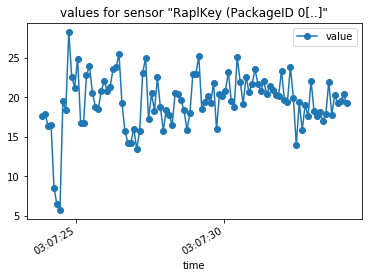

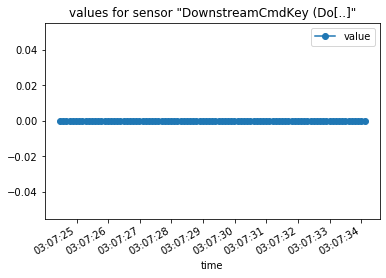

In [11]:
for sensorID, measurements in history.items():
    dataframe = pd.DataFrame(
        data=[(pd.Timestamp(t, unit="us"), m) for t, m in measurements]
    )
    dataframe.columns = ["time", "value"]
    dataframe = dataframe.set_index("time")
    ax = dataframe.plot(
        marker="o", linestyle="-", title='values for sensor "%s[..]"' % sensorID[:20]
    )